이 코드는 다음 순서로 작동한다

1. 후처리할 이미지들이 있는 폴더를 선택한다
2. 초반 300개의 이미지를 평균내서 평균 이미지를 변수선언한다
3. 모든 이미지의 중앙에 있는 이미지를 골라서 대표 이미지로 정한다
4. 대표 이미지에서 평균 이미지를 빼고, 각 픽셀값에 2**15-1를 더해준다 이를 평균 제거된 이미지 라고 한다
5. 평균 제거된 이미지의 각 픽셀 밝기를 2**15-1에서 떨어진 거리를 x배 해주는 방식으로 대비를 증가시키고, x에 따른 이미지를 보고 x를 선택한다
6. 모든 이미지 중 100개 간격으로 이미지를 샘플링해서 선택된 x에 따라 대표 이미지를 후처리 한것처럼 똑같이 후처리하여 각각 별개의 폴더에 저장한다. 저장위치는 초반에 선택했던 이미지 옆에 폴더를 만든다 각각이란 말은 평균제거된 이미지와 대비 증가된 이미지를 말한다
7. 간격으로
모든 이미지는 tiff 16bit 흑백 이미지이다
이미지 파일명은 Img000000.tif로 시작하여 Img000001.tif Img000002.tif 이런식이다

In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import cv2
from tqdm import tqdm  # 진행상황 확인용\
import matplotlib.pyplot as plt
from tqdm import tqdm

In [35]:
# Tkinter 창 숨기기
root = tk.Tk()
root.withdraw()

# 폴더 선택 창 열기
folder_path = filedialog.askdirectory(title="후처리할 이미지 폴더를 선택하세요.")

# 선택된 경로 출력 확인
if folder_path:
    print(f"선택된 폴더: {folder_path}")
else:
    print("폴더 선택이 취소되었습니다.")
# folder_path 는 이전 코드에서 선택된 폴더 경로를 사용
# 예: folder_path = "/Users/.../이미지폴더"

선택된 폴더: /Volumes/T7 Shield/high speed camera/251003 exp#146/Test1/32222_1_481


In [36]:
# 폴더 내 모든 tif 파일명 정렬해서 가져오기
file_list = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.tif') and f.startswith('Img')])

# 이미지 불러오기 및 저장
images = []

for file_name in tqdm(file_list, desc="이미지 불러오는 중"):
    file_path = os.path.join(folder_path, file_name)
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)  # 16bit grayscale 그대로 읽기
    if img is None:
        raise ValueError(f"{file_name} 을 불러오는 데 실패했습니다.")
    if len(img.shape) != 2:
        raise ValueError(f"{file_name} 는 2D grayscale 이미지가 아닙니다.")
    images.append(img.astype(np.float64))  # 이후 계산을 위해 float64 변환

# images 는 numpy array 리스트
print(f"{len(images)}개의 이미지를 성공적으로 불러왔습니다.")

이미지 불러오는 중: 100%|██████████| 9961/9961 [00:37<00:00, 265.70it/s]

9961개의 이미지를 성공적으로 불러왔습니다.


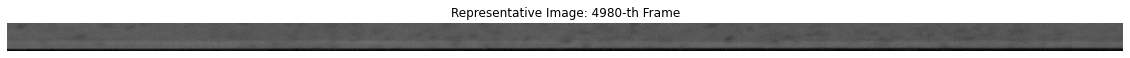

In [37]:
# 중간 index 선택
mid_index = len(images) // 2
representative_img = images[mid_index]

# 확인용 imshow (0 ~ 65535, 16bit 이므로 cmap='gray'로)
plt.figure(figsize=(20, 8))
plt.imshow(representative_img, cmap='gray', vmin=0, vmax=65535)
plt.title(f"Representative Image: {mid_index}-th Frame")
plt.axis('off')
plt.show()


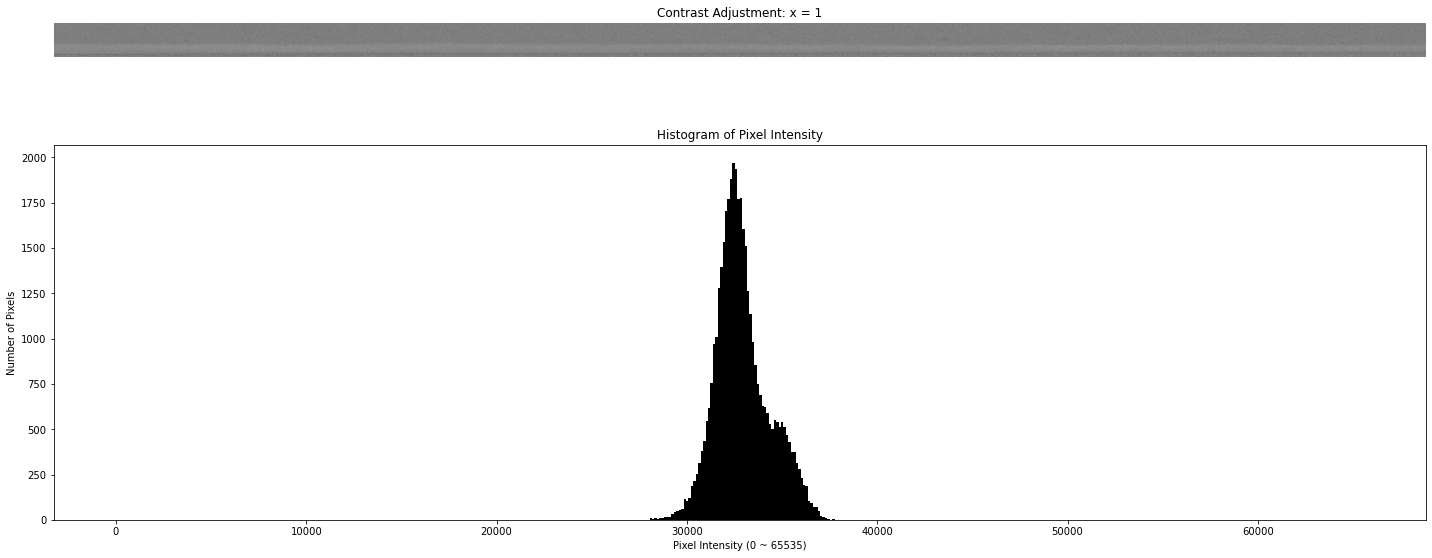

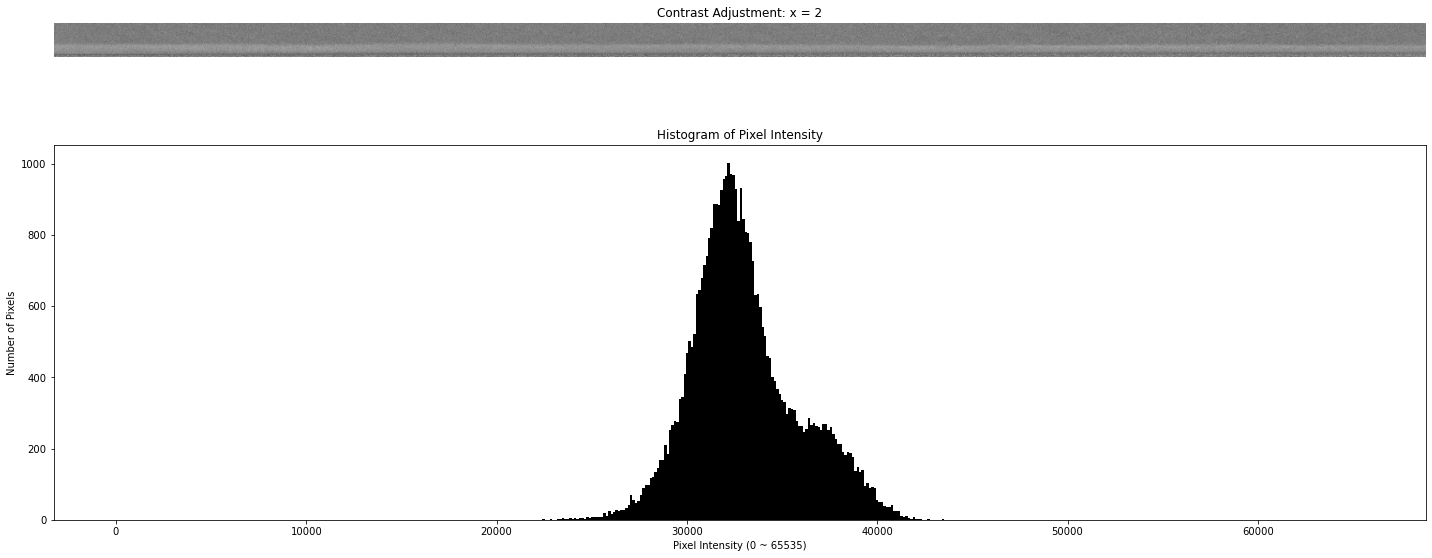

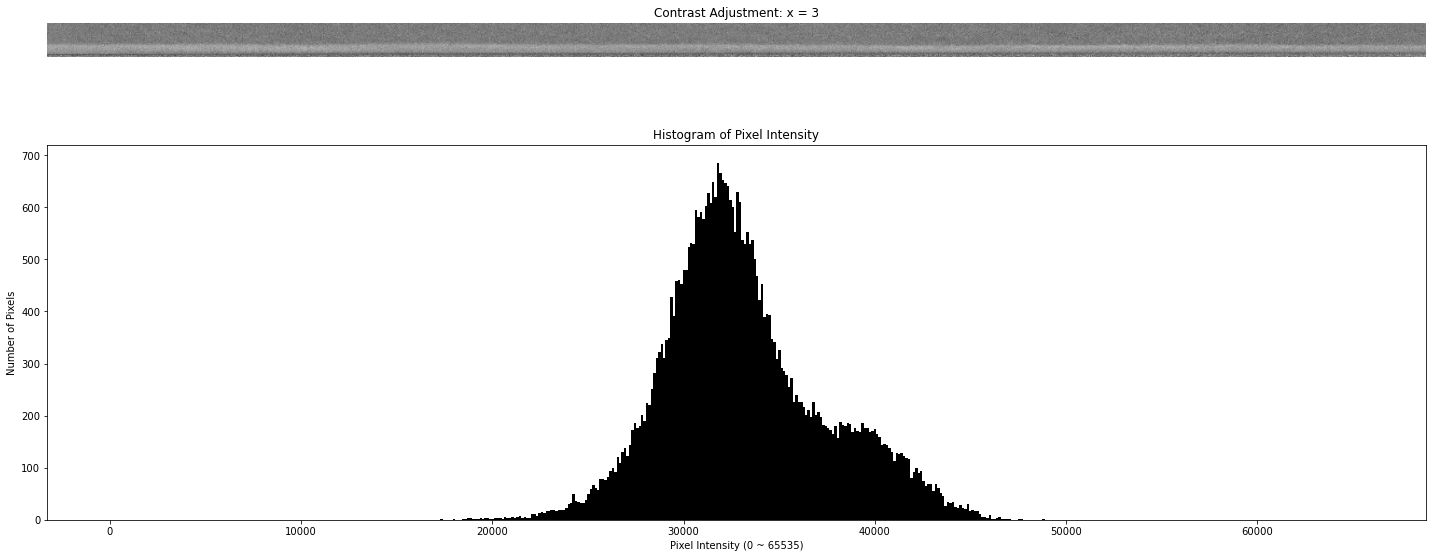

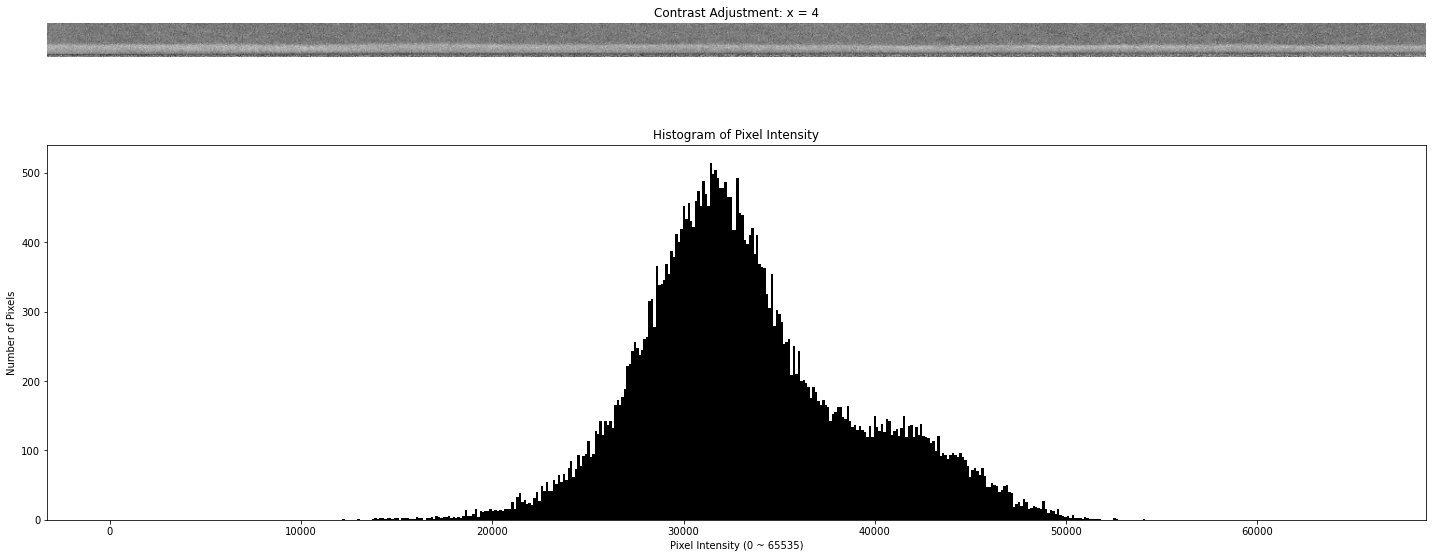

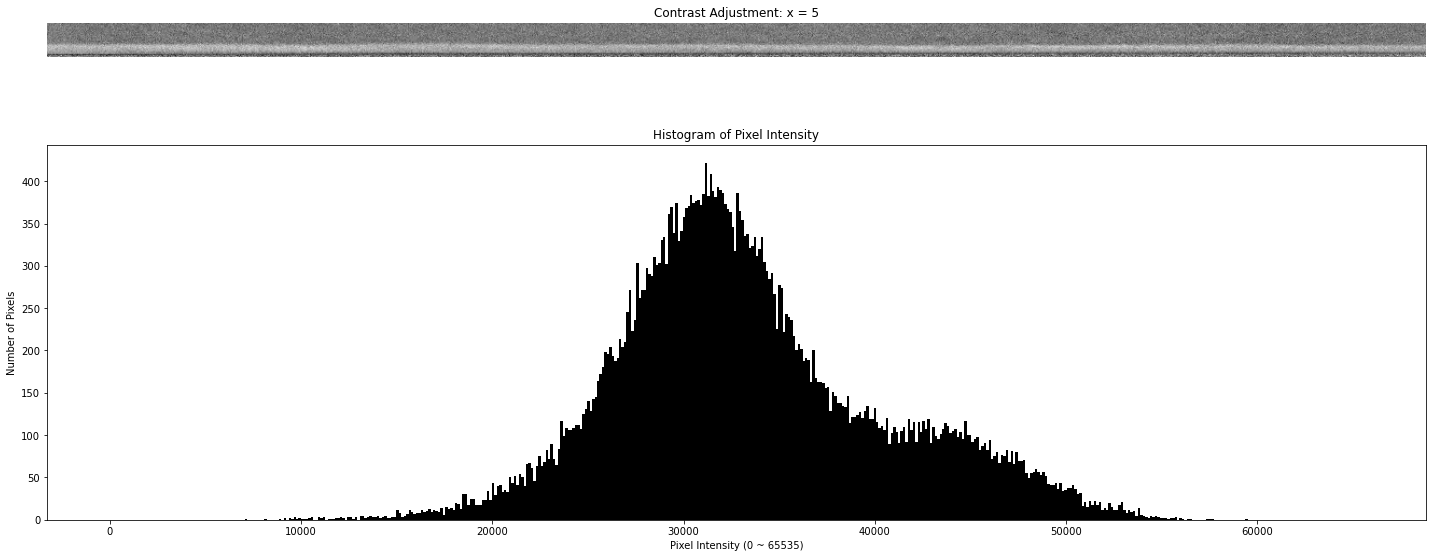

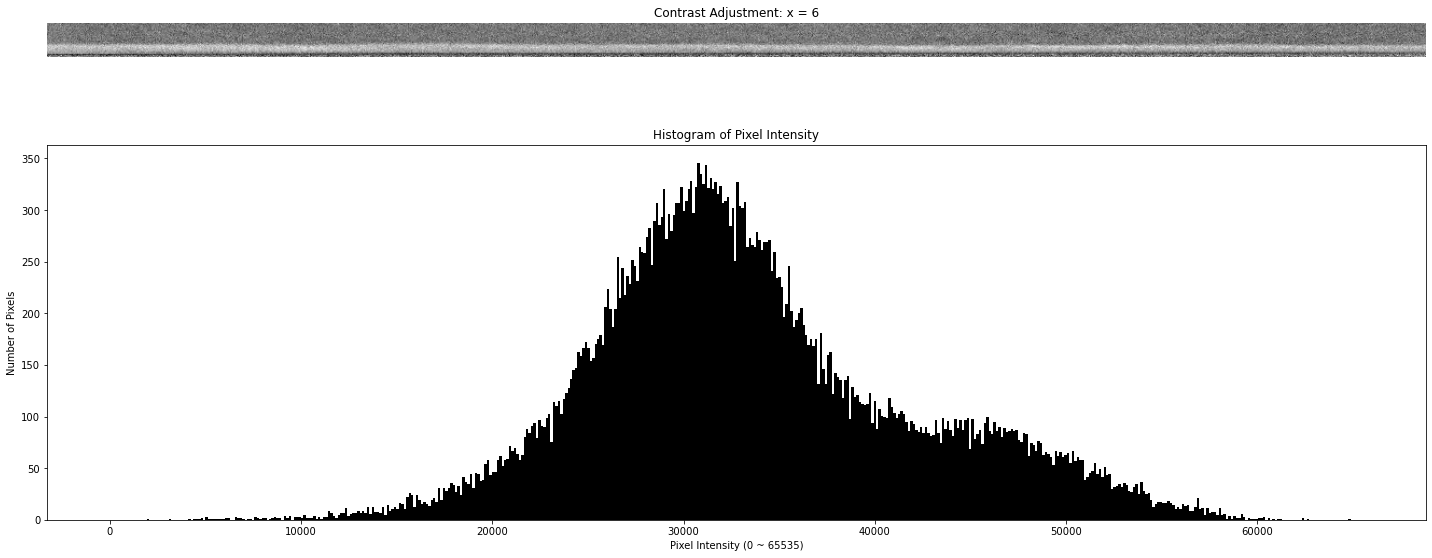

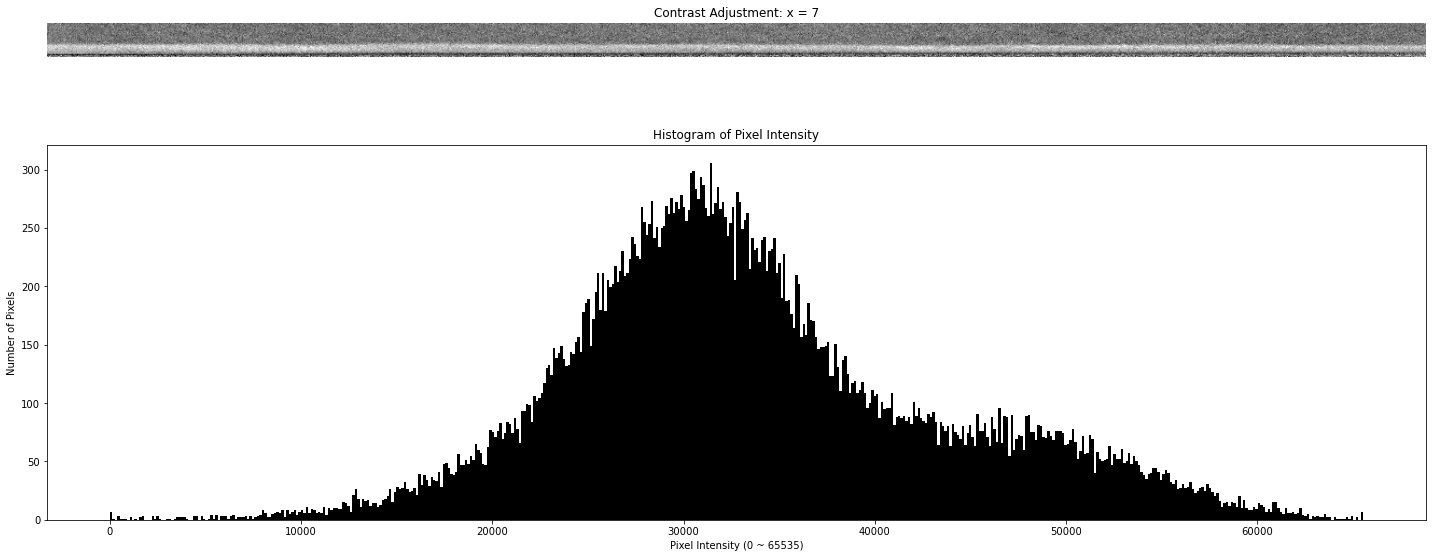

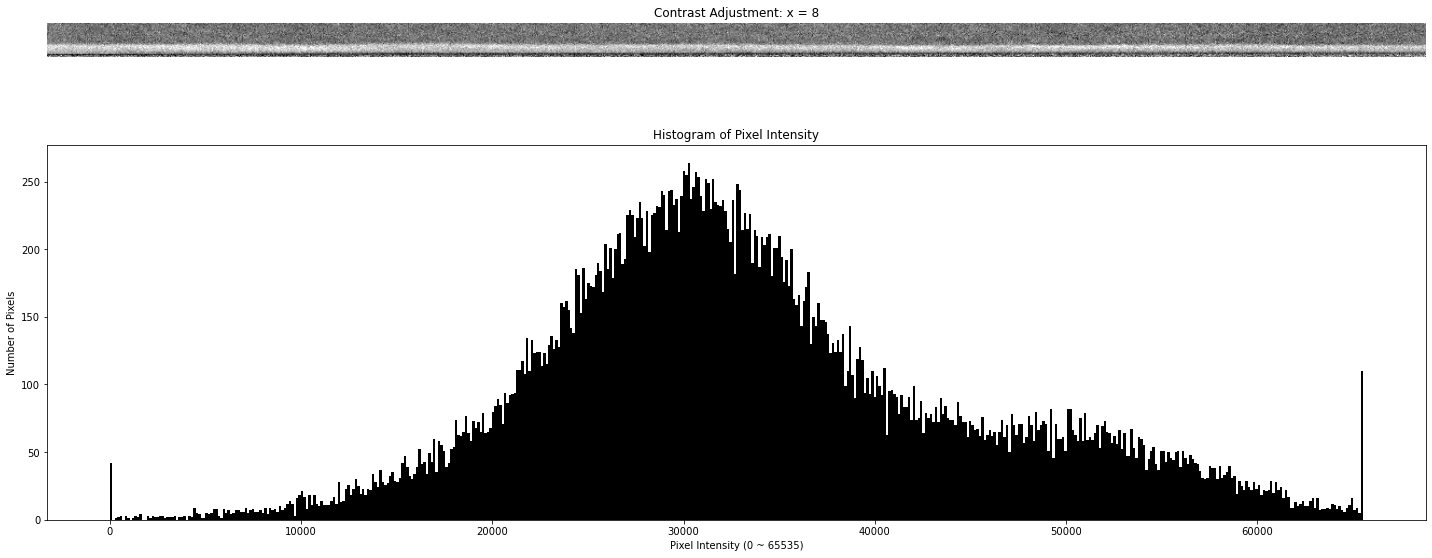

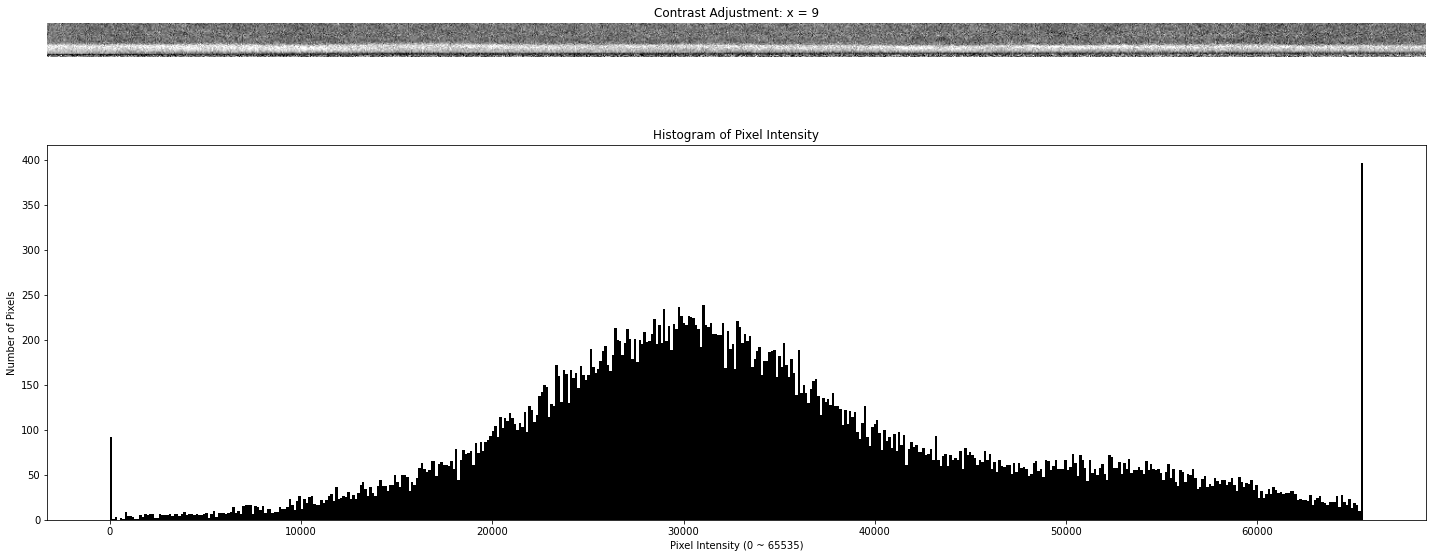

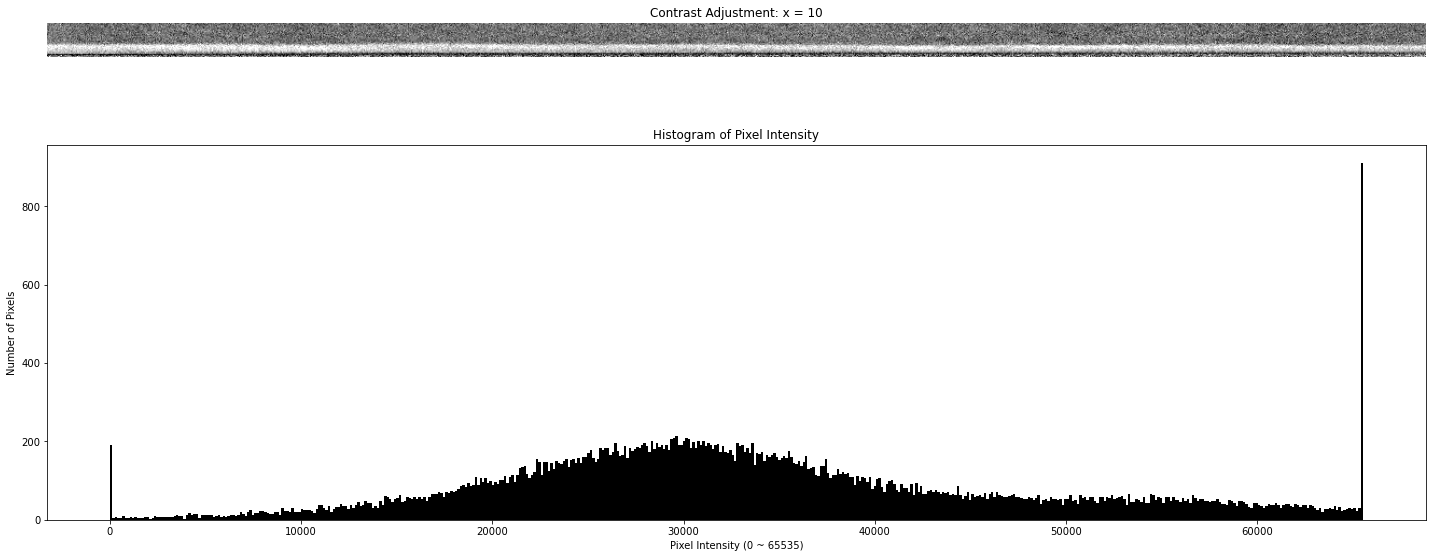

In [38]:
# 1. 초반 300장 평균
num_avg = 300  
avg_img = np.mean(images[:num_avg], axis=0)

# 2. 대표 이미지 - 평균
diff_img = representative_img - avg_img

# 3. 언더플로 방지용 +32767
offset = 2**15 - 1  # 32767
processed_img = diff_img + offset

for x in range(1, 11):
    # 대비 조절
    contrast_img = offset + (processed_img - offset) * x
    contrast_img = np.clip(contrast_img, 0, 65535)

    # Figure 준비
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))

    # 1️⃣ 이미지 표시
    axes[0].imshow(contrast_img, cmap='gray', vmin=0, vmax=65535)
    axes[0].set_title(f"Contrast Adjustment: x = {x}")
    axes[0].axis('off')

    # 2️⃣ 히스토그램 표시
    axes[1].hist(contrast_img.ravel(), bins=512, range=(0, 65535), color='black')
    axes[1].set_xlabel("Pixel Intensity (0 ~ 65535)")
    axes[1].set_ylabel("Number of Pixels")
    axes[1].set_title("Histogram of Pixel Intensity")

    plt.tight_layout()
    plt.show()


In [31]:
x=7. #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [39]:
# 저장 폴더 설정
parent_folder = os.path.dirname(folder_path)
save_folder_avg = os.path.join(parent_folder, "Average_Removed")
save_folder_contrast = os.path.join(parent_folder, "Contrast")

os.makedirs(save_folder_avg, exist_ok=True)
os.makedirs(save_folder_contrast, exist_ok=True)

# 샘플링 및 저장
for idx in tqdm(range(0, len(images), 100), desc="Saving images..."):
    img = images[idx]
    
    # 평균 제거
    avg_removed = img - avg_img + offset
    avg_removed = np.clip(avg_removed, 0, 65535)
    
    # 대비 증가
    contrast_img = offset - (avg_removed - offset) * x # 괄호 앞 부호 확인!!!!@@@@@@@@@@@@@@@@@@@@@@@@@@@
    contrast_img = np.clip(contrast_img, 0, 65535)

    # uint16로 변환
    avg_removed_uint16 = avg_removed.astype(np.uint16)
    contrast_uint16 = contrast_img.astype(np.uint16)

    # 파일명 변환: Img000100.tif → 000100.tif
    file_num = str(idx).zfill(6)
    filename = file_num + ".tif"

    # 저장
    cv2.imwrite(os.path.join(save_folder_avg, filename), avg_removed_uint16)
    cv2.imwrite(os.path.join(save_folder_contrast, filename), contrast_uint16)

print("모든 이미지 저장 완료.")
print(f"평균 제거 폴더: {save_folder_avg}")
print(f"대비 증가 폴더: {save_folder_contrast}")


Saving images...: 100%|██████████| 100/100 [00:01<00:00, 85.94it/s]

모든 이미지 저장 완료.
평균 제거 폴더: /Volumes/T7 Shield/high speed camera/251003 exp#146/Test1/Average_Removed
대비 증가 폴더: /Volumes/T7 Shield/high speed camera/251003 exp#146/Test1/Contrast


In [40]:
start_frame =1000 #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
end_frame = start_frame + int(5/1000*1.5e6)   #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

for idx in tqdm(range(start_frame, end_frame + 1), desc="Processing images"):
    img = images[idx]

    # 평균 제거
    avg_removed = img - avg_img + offset
    avg_removed = np.clip(avg_removed, 0, 65535)

    # 대비 증가
    contrast_img = offset - (avg_removed - offset) * x # 괄호 앞 부호 확인!!!!@@@@@@@@@@@@@@@@@@@@@@@@@@@
    contrast_img = np.clip(contrast_img, 0, 65535)

    # uint16 변환
    avg_removed_uint16 = avg_removed.astype(np.uint16)
    contrast_uint16 = contrast_img.astype(np.uint16)

    # 파일명: 000100.tif
    file_num = str(idx).zfill(6)
    filename = file_num + ".tif"

    # 저장
    cv2.imwrite(os.path.join(save_folder_avg, filename), avg_removed_uint16)
    cv2.imwrite(os.path.join(save_folder_contrast, filename), contrast_uint16)


Processing images: 100%|██████████| 7501/7501 [01:14<00:00, 101.33it/s]


In [17]:
# Tkinter 창 숨기기
root = tk.Tk()
root.withdraw()

# 폴더 선택 창 열기
folder_path = filedialog.askdirectory(title="후처리할 이미지 폴더를 선택하세요.")

# 선택된 경로 출력 확인
if folder_path:
    print(f"선택된 폴더: {folder_path}")
else:
    print("폴더 선택이 취소되었습니다.")
# folder_path 는 이전 코드에서 선택된 폴더 경로를 사용
# 예: folder_path = "/Users/.../이미지폴더"

선택된 폴더: D:/high speed camera/250725 exp#134/Test1/32222_1_458


In [41]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# =====================
# 설정값
# =====================
camera_fps = 1.5e6  # 원본 촬영 fps
fps = 60            # 출력 mp4 fps

that_frame=1530
that_time=1.
ready_time=0.3808
test_time=2.1

# start_frame_new = that_frame+ int(ready_time/1000 * 1.5e6)
start_frame_new=2101

end_frame_new = start_frame_new + int(test_time/1000 * 1.5e6)  # 3ms 구간



# time_start_ms = that_time - (that_frame - start_frame_new) * 1000 / camera_fps
time_start_ms=0

# Contrast 폴더 및 저장 경로
parent_folder = os.path.dirname(folder_path)
contrast_folder = os.path.join(parent_folder, "Contrast")
video_name = f"time_overlay_{start_frame_new}-{end_frame_new}_{fps}Hz.mp4"
save_video_path = os.path.join(parent_folder, video_name)

# 첫 프레임 읽어 사이즈 획득
first_img_path = os.path.join(contrast_folder, str(start_frame_new).zfill(6) + ".tif")
first_img = cv2.imread(first_img_path, cv2.IMREAD_UNCHANGED)
if first_img is None:
    raise FileNotFoundError(f"첫 프레임 {first_img_path} 을 찾을 수 없습니다.")
orig_height, orig_width = first_img.shape

# 상단 여백 크기
top_margin = 80  # px, 원하는 만큼 조정 가능
frame_height = orig_height + top_margin
frame_width = orig_width

# VideoWriter 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(save_video_path, fourcc, fps, (frame_width, frame_height), isColor=False)

# 폰트 설정
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.2
font_color = 255   # 흰색 글자
thickness = 2
position = (20, int(top_margin / 1.5))  # 여백 위쪽에 위치

# 시간 스텝 (ms/frame)
time_step_ms = 1000 / camera_fps
total_frame = end_frame_new - start_frame_new + 1

# =====================
# 프레임 처리
# =====================
for i, idx in enumerate(tqdm(range(start_frame_new, end_frame_new + 1), desc="Creating video with time overlay")):
    file_num = str(idx).zfill(6) + ".tif"
    img_path = os.path.join(contrast_folder, file_num)

    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        continue

    # 16bit → 8bit 변환
    img_8bit = (img / 256).astype('uint8')

    # 상단 여백 추가 (검정 배경)
    frame = np.zeros((frame_height, frame_width), dtype=np.uint8)
    frame[top_margin:, :] = img_8bit

    # 시간 텍스트
    time_ms = time_start_ms + i * time_step_ms
    text = f"+{time_ms:.3f} ms"
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness)

    # 프레임 저장
    out.write(frame)

out.release()
print(f"Video saved with time overlay: {save_video_path}")


Creating video with time overlay: 100%|██████████| 3151/3151 [00:17<00:00, 178.34it/s]


Video saved with time overlay: /Volumes/T7 Shield/high speed camera/251003 exp#146/Test1/time_overlay_2101-5251_60Hz.mp4


In [ ]:
# # 새 범위 지정
# start_frame_new = 3000   #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# end_frame_new = 3000+ int(3/1000*1.5e6)     #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# fps = 60    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# mp4_name=str(start_frame_new) +'-'+str(end_frame_new)+'_'+str(fps)+'Hz.mp4'

# # Contrast 폴더
# parent_folder = os.path.dirname(folder_path)
# contrast_folder = os.path.join(parent_folder, "Contrast")

# # 영상 저장 경로
# save_video_path = os.path.join(parent_folder, mp4_name)

# # 첫 이미지로 사이즈 획득
# first_img_path = os.path.join(contrast_folder, str(start_frame_new).zfill(6) + ".tif")
# first_img = cv2.imread(first_img_path, cv2.IMREAD_UNCHANGED)
# if first_img is None:
#     raise FileNotFoundError(f"첫 프레임 {first_img_path} 을 찾을 수 없습니다.")
# height, width = first_img.shape

# # mp4 writer (16bit 불가, uint8 변환 필요)
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(save_video_path, fourcc, fps, (width, height), isColor=False)

# # 프레임 저장
# for idx in tqdm(range(start_frame_new, end_frame_new + 1), desc="Creating video"):
#     file_num = str(idx).zfill(6) + ".tif"
#     img_path = os.path.join(contrast_folder, file_num)

#     img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#     if img is None:
#         continue  # 없는 파일은 skip

#     # 16bit -> 8bit 변환
#     img_8bit = (img / 256).astype('uint8')

#     # cv2.VideoWriter expects 3 channel or single channel 8bit
#     out.write(img_8bit)

# out.release()
# print(f"Video saved: {save_video_path}")

# import cv2
# import numpy as np
# import os
# from tqdm import tqdm

# # 설정값
# camera_fps = 1.5e6  # 1.5 million fps
# fps = 60  # 영상 출력용 프레임레이트
# start_frame_new = 3000   #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# end_frame_new = 3000+ int(3/1000*1.5e6)     #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# width, height = 500, 300
# time_start_ms=8.5-(3321-3000)*1000/camera_fps
# time_bar_name='time_bar'+str(start_frame_new) +'-'+str(end_frame_new)+'_'+str(fps)+'Hz.mp4'

# # 영상 저장 경로
# save_video_path = os.path.join(parent_folder, time_bar_name)

# # 총 프레임 수 (촬영 프레임 개수)
# total_frame = end_frame_new - start_frame_new + 1

# # VideoWriter 설정
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(save_video_path, fourcc, fps, (width, height), isColor=True)

# # 폰트 설정
# font = cv2.FONT_HERSHEY_SIMPLEX
# font_scale = 2.0
# font_color = (0, 0, 0)
# thickness = 3
# position = (50, int(height / 2))

# # 카메라 기준 밀리초 간격
# time_step_ms = 1000 / camera_fps  # 1000 ms / 1.5e6 frames

# # 프레임 생성
# for i in tqdm(range(total_frame), desc="Creating time-only video (camera ms)"):
#     # 현재 시간 (ms)
#     time_ms = i * time_step_ms+time_start_ms

#     img = np.full((height, width, 3), 255, dtype=np.uint8)  # 흰색 배경
#     text = f"+{time_ms:.3f} ms"
#     cv2.putText(img, text, position, font, font_scale, font_color, thickness)
#     out.write(img)

# out.release()
# print(f"Video saved (Time-Only, camera ms): {save_video_path}")


Creating video:  21%|██        | 956/4501 [00:02<00:10, 333.06it/s]


KeyboardInterrupt: 